In this document I'll be demonstrating the behaviour of a variety of filters I've played with that motivate our filtering choices. I have zero knowledge of the math of filtering; all I have done here is the result of simply playing with code. I strongly suspect that there are better ways of doing things than I've achieved here, and hope this document can serve to give some background on what we've tried.

First we'll do imports and set up a default plotting theme:

In [40]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal

#set plot style
plt.style.use('ggplot')

Next, let's generate a time vector and a signal that can stand-in for a typical human pulse of about 1Hz:

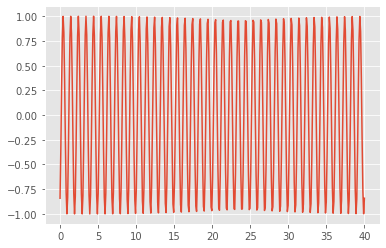

In [86]:
#generate time vector
samples_per_sec = 10.0
total_time = 40.0
time = np.linspace(0, total_time, int(total_time*samples_per_sec))

#generate the pulse signal
pulse_hz = 1.0
pulse = np.sin(time*(2*np.pi)*pulse_hz - pulse_hz)
plt.plot(time, pulse);

Looks good. Now, let's add a lower-amplitude signal to represent the brain response to an event that happens at the 10s mark and ends at the 20s mark (ie peaks at 20s, and decays thereafter):

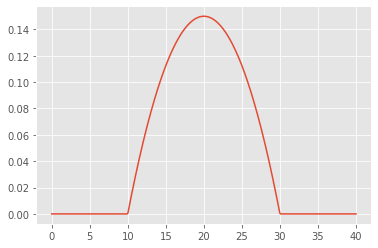

In [42]:
#generate the bold signal (just something that goes up then down)
dist = stats.beta(2, 2)
bold = dist.pdf((time-10)/20) / 10.0 # division by 10 to make bold a small signal
plt.plot(time, bold);

Now combine the two signals to emulate what we'd observe:

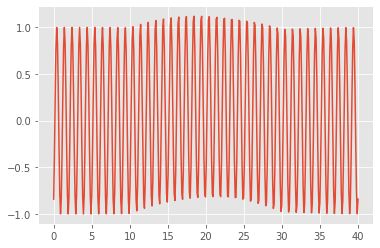

In [43]:
#combine
pulse_plus_bold = pulse+bold
plt.plot(time, pulse_plus_bold);

So there's our pulse-dominated signal. We want to do a band-stop filter to elimiante a range of reasonable human pulse values (since we won't know precisely what the pulse is for a given person). Butterworth filters seem to be pretty well-recommended, so let's create one and look at its frequency response:

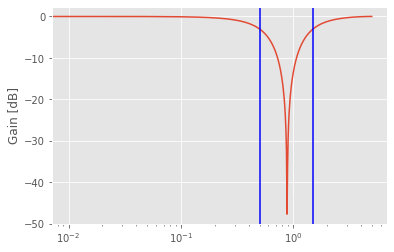

In [44]:
#1st order butterworth filter in ba mode
ba1 = signal.butter(
	output = 'ba'
	, N = 1 #needs to be low if using output='ba', else use output='sos' and sosfiltfilt
	, Wn = [0.5,1.5]
	, btype = 'bandstop'
	, fs = samples_per_sec
)
w, h = signal.freqz(ba1[0], ba1[1],fs=samples_per_sec)
plt.semilogx(w, 20*np.log10(abs(h)));
plt.axvline(0.5, color='blue');
plt.axvline(1.5, color='blue');
plt.ylabel('Gain [dB]');

OK, so we can see that there's a large attenuation peaking in the middle of our desired stop band. Let's apply this filter to the data. Simple application of the filter might cause a phase delay in the signal we're interested in, and we'd like to avoid that. So instead we'll use the `filtfilt` method, which seems to be well-recommended as a means of filtering that does not induce any phase delays. There are a variety of padding options when using `filtfilt`, but first lets look at what happens when we don't do any padding at all:

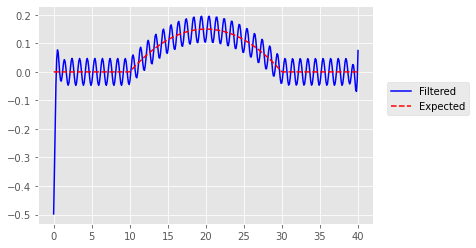

In [63]:
#filter using ba1, filtfilt and default pading
filtered_ba1_nopad = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse_plus_bold
	, padtype = None
)
plt.plot(time, filtered_ba1_nopad, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Ok, possibly as expected given we didn't pad, we observe some transient distortion at the edges. Let's try padding with a constant:

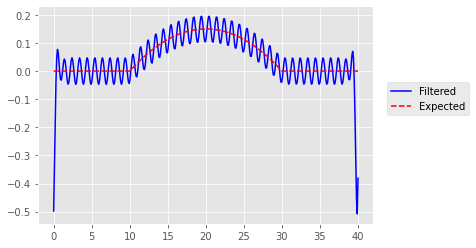

In [64]:
#filter using ba1, filtfilt and constant padding
filtered_ba1_pad_constant = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse_plus_bold
	, method = 'pad'
    , padtype = 'constant'
)
plt.plot(time, filtered_ba1_pad_constant, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Huh. Seems actually worse! The distortion happens at both sides now. Maybe a longer padlength will help?

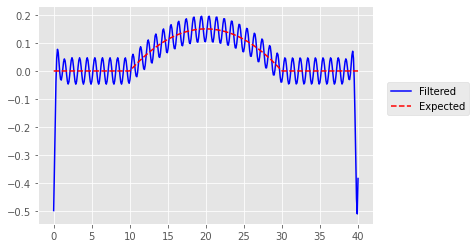

In [67]:
#filter using ba1, filtfilt and constant padding
filtered_ba1_pad_constant_maxlength = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse_plus_bold
	, method = 'pad'
    , padtype = 'constant'
    , padlen = len(pulse_plus_bold)-1
)
plt.plot(time, filtered_ba1_pad_constant_maxlength, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Nope, seems to yield identical results. How about a non-constant pad, of which there are the options for "even" and "odd". First "odd"

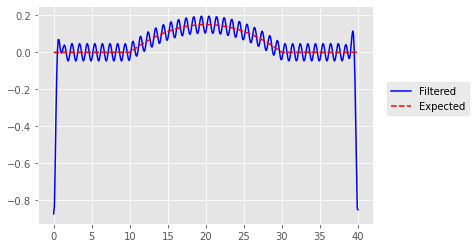

In [69]:
filtered_ba1_pad_odd = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse_plus_bold
	, method = 'pad'
    , padtype = 'odd'
)
plt.plot(time, filtered_ba1_pad_odd, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Actually even worse (larger magnitude). How about even:

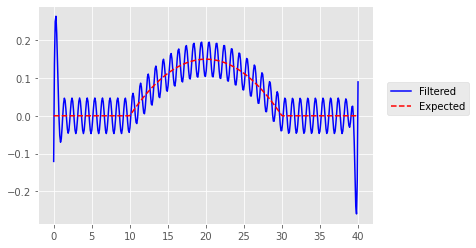

In [70]:
filtered_ba1_pad_even = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse_plus_bold
	, method = 'pad'
    , padtype = 'even'
)
plt.plot(time, filtered_ba1_pad_even, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Oh, better! The amplitude of distortion has decreased. This makes me wonder if the difference between odd and even is sensitive to the phase of the signal. Let's re-create the signa with the pulse at 180 and see if we get a reversal of which pad type works better:

In [2]:
import ipywidgets as widgets
widgets.FloatSlider()

FloatSlider(value=0.0)

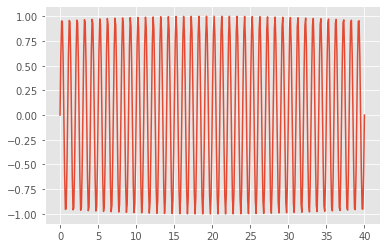

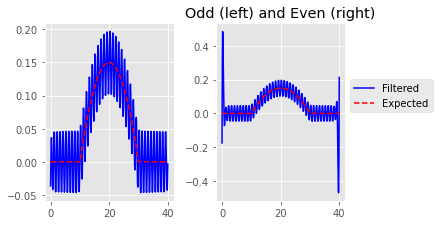

In [89]:

#sine = function(time,hz,phase) sin(time*(2*pi)*hz - phase*hz)
pulse = np.sin(time*(2*np.pi)*pulse_hz - pulse_hz*np.pi)

pulse180 = -pulse
plt.plot(time, pulse180);
pulse180_plus_bold = pulse180+bold

filtered180_ba1_pad_odd = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse180_plus_bold
	, method = 'pad'
    , padtype = 'odd'
)
filtered180_ba1_pad_even = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse180_plus_bold
	, method = 'pad'
    , padtype = 'even'
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].plot(time, filtered180_ba1_pad_odd, 'b')
axes[0].plot(time, bold, 'r--')
axes[1].plot(time, filtered180_ba1_pad_even, 'b')
axes[1].plot(time, bold, 'r--')
fig.tight_layout()
plt.title('Odd (left) and Even (right)')
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

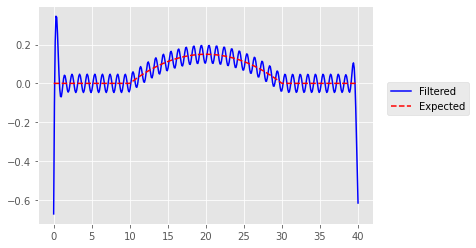

In [66]:
#filter using ba1, filtfilt and gust pading
filtered_ba1_gust = signal.filtfilt(
	b = ba1[0]
	, a = ba1[1]
	, x = pulse_plus_bold
	, method = 'gust'
)
plt.plot(time, filtered_ba1_gust, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Next we try a high-order filter. I choose 22 merely because it looks different in the variable names than 1 and reflects a rather high order for this comparison. The standard "ba" output should have numeric errors in this case.

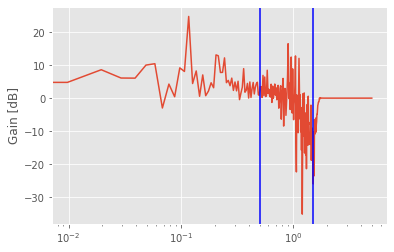

In [26]:
#22nd order butterworth filter in ba mode
# This 
ba22 = signal.butter(
	output = 'ba'
	, N = 22
	, Wn = [0.5,1.5]
	, btype = 'bandstop'
	, fs = samples_per_sec
)
#print(ba8)
w, h = signal.freqz(ba22[0], ba22[1],fs=samples_per_sec)
plt.semilogx(w, 20*np.log10(abs(h)));
plt.axvline(0.5, color='blue');
plt.axvline(1.5, color='blue');
plt.ylabel('Gain [dB]');

Yup! But let's try using it anyway, first the default padding:

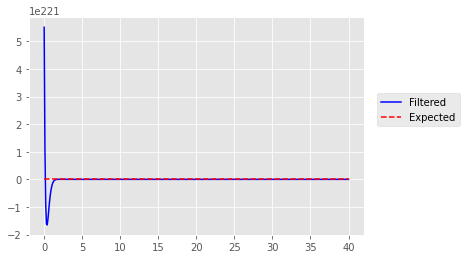

In [27]:
#filter using ba22, filtfilt and default pading
filtered_ba22_pad = signal.filtfilt(
	b = ba22[0]
	, a = ba22[1]
	, x = pulse_plus_bold
	, method = 'pad'
)
plt.plot(time, filtered_ba22_pad, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Yikes! How about gust padding?

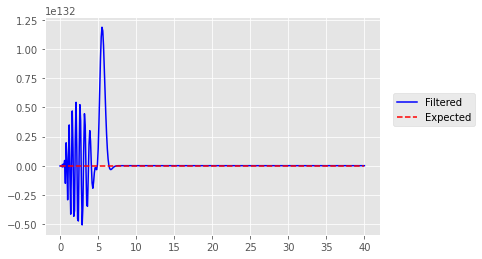

In [28]:
#filter using ba22, filtfilt and gust pading
filtered_ba22_gust = signal.filtfilt(
	b = ba22[0]
	, a = ba22[1]
	, x = pulse_plus_bold
	, method = 'gust'
)
plt.plot(time, filtered_ba22_gust, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

Still terrible. That's why we don't use 'ba' mode for high-order filters, and instead use 'sos' mode:

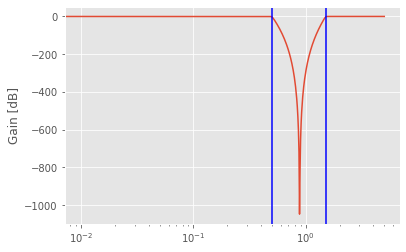

In [34]:
#22nd order butterworth filter in ba mode
sos22 = signal.butter(
	output = 'sos'
	, N = 22
	, Wn = [0.5,1.5]
	, btype = 'bandstop'
	, fs = samples_per_sec
)
#print(ba8)
w, h = signal.sosfreqz(sos22,fs=samples_per_sec)
plt.semilogx(w, 20*np.log10(abs(h)));
plt.axvline(0.5, color='blue');
plt.axvline(1.5, color='blue');
plt.ylabel('Gain [dB]');

Much better! And for comparison, here's the first-order that worked above again:

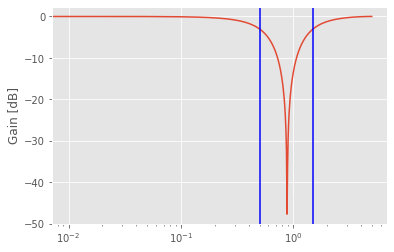

In [37]:
w, h = signal.freqz(ba1[0], ba1[1],fs=samples_per_sec)
plt.semilogx(w, 20*np.log10(abs(h)));
plt.axvline(0.5, color='blue');
plt.axvline(1.5, color='blue');
plt.ylabel('Gain [dB]');

The higher order filter has sharper behaviour, leaving the passband relatively unmodified while more rapidly attenuating the stop band. Here's how it looks when applied to the data:

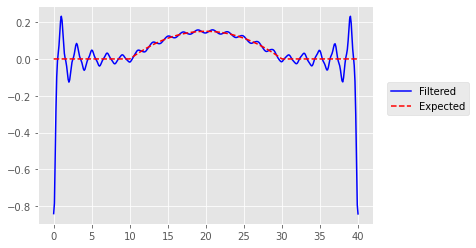

In [36]:
#filter using sos22, sosfiltfilt
filtered_sos22 = signal.sosfiltfilt(
	sos = sos22
	, x = pulse_plus_bold
)
plt.plot(time, filtered_sos22, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

There's no 'gust' padding available for sosfiltfilt however, so we have to accept the default padding behaviour. For comparison, here's the first-oder filtering result from above again:

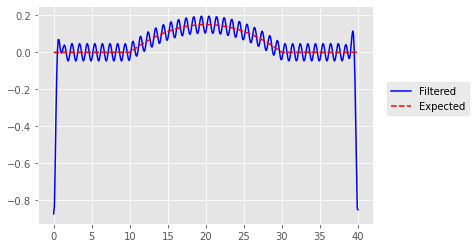

In [38]:
plt.plot(time, filtered_ba1_pad, 'b');
plt.plot(time, bold, 'r--');
plt.legend(['Filtered', 'Expected'], loc=(1.04,.5));

So, in the middle of the signal, the higher-order signal has removed more of the pulse than the lower-order signal. However, the higher-order filter manifests stronger edge distortions that are creeping further into the body of the signal than the lower-order filter. 